In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
%matplotlib inline
import calendar
import time

import boto
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from matplotlib import cm, colors
from sklearn import preprocessing
from sklearn.cross_decomposition import CCA

from src import plot_heatmaps
from src import read_nwp_data
from src import format_error_df

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def canonical(lulc):
    X = lulc.drop(columns="error")
    Y = lulc[["error"]]
    X_mc = (X - X.mean()) / (X.std())
    Y_mc = (Y - Y.mean()) / (Y.std())
    ca = CCA(n_components=1)
    ca.fit(X_mc, Y_mc)
    X_c, Y_c = ca.transform(X_mc, Y_mc)
    cc_res = pd.DataFrame(
        {
            "CCX_1": X_c[:, 0],
            "CCY_1": Y_c[:, 0],
            "11": lulc["elev"].tolist(),
            "21": lulc["std"].tolist(),
            "22": lulc["variance"].tolist(),
            "23": lulc["skew"].tolist(),
            "24": lulc["med_dist"].tolist(),
            "31": lulc["lat"].tolist(),
            "41": lulc["lon"].tolist(),
        }
    )
    corr = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    return corr

In [4]:
def main(months_df, lulc):
    corr_ls = []
    for i in np.arange(1, 13):
        df = months_df[months_df["time"] == i]
        months = df["t2m_error"].to_list()
        lulc["error"] = months
        corr = canonical(lulc)
        corr_ls.append(corr)
    return corr_ls

In [5]:
init = "12"

(
    gfs_fcast_and_error_df,
    nam_fcast_and_error_df,
    hrrr_fcast_and_error_df,
) = read_nwp_data.read_data(init)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [6]:
lulc = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/elev_hrrr.csv")
lulc = lulc.drop(columns=["Unnamed: 0", "station"])
lulc = lulc.fillna(0)
keys = lulc.keys()

In [7]:
keys

Index(['elev', 'std', 'variance', 'skew', 'med_dist', 'lon', 'lat'], dtype='object')

# HRRR

In [9]:
months_df = format_error_df.format_df(hrrr_fcast_and_error_df)

In [10]:
corr_ls = main(months_df, lulc)

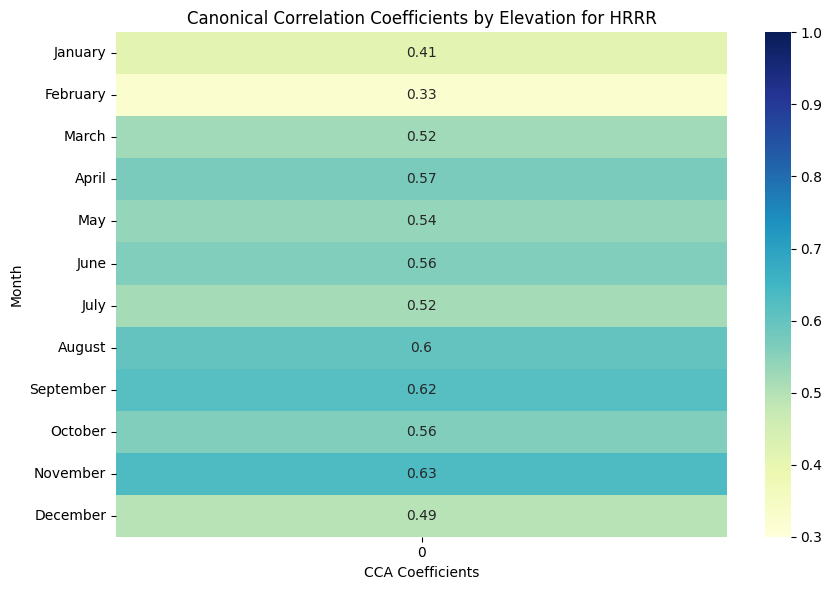

In [11]:
plot_heatmaps.plot_heatmap(corr_ls, "HRRR", "Elevation")

In [12]:
# # Obtain the rotation matrices
# xrot = ca.x_rotations_
# yrot = ca.y_rotations_

# # Put them together in a numpy matrix
# xyrot = np.vstack((xrot,yrot))

# nvariables = xyrot.shape[0]

# plt.figure(figsize=(15, 15))
# plt.xlim((-1,1))
# plt.ylim((-1,1))

# # Plot an arrow and a text label for each variable
# for var_i in range(nvariables):
#   x = xyrot[var_i,0]
#   y = xyrot[var_i,1]

#   plt.arrow(0,0,x,y)
#   plt.text(x,y,data.columns[i], color='red' if i >= 6 else 'blue')

# plt.show()